# A Notebook showing 'reverse Deconvolution' a.k.a. PSF Distilling

## This version of the notebook has been tweaked for a question on image.sc

[See this link for data](https://forum.image.sc/t/pyme-psfextraction-creates-psfs-with-higher-than-expected-intensity-in-outer-rings/62973/3)

In this notebook we perform a reverse deconvolution to solve for the PSF.  The acquired image is the convolution of a PSF and a 'true object'.  The 'true object' is the deconvolution of the image using the PSF.  However if we know the true object (in this case a field of sub-resolution beads) we can reverse the role of object and PSF, and solve for the PSF
```
Image=convolution(object,psf)

object=deconvolution(image,psf)

psf=deconvolution(image,object)
```

The notebook shows how to create a 'true object' from a field of sub-resolution beads using the prior knowledge of the shape of the beads (a sub-resolution point).  Then use the 'true object' to find an aproximation of the PSF using a reverse deconvolution

## Imports

In [43]:
from skimage.io import imread
from tnia.plotting.projections import show_xyz_max
from skimage.filters import threshold_otsu, threshold_local
from skimage.measure import label

## Load Image

Here we load a test image that was provided on image.sc by Claire Mitchell [see here]((https://forum.image.sc/t/pyme-psfextraction-creates-psfs-with-higher-than-expected-intensity-in-outer-rings/62973/3)  

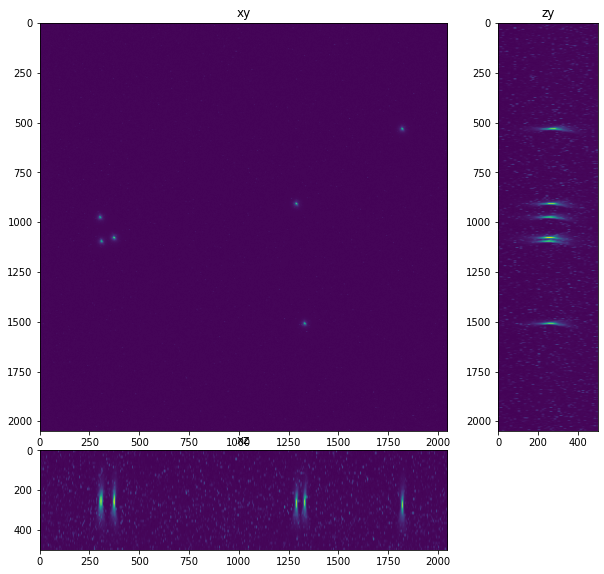

In [44]:
dir = 'D:\\images\\tnia-python-images\\notebooks\\deconvolution\\PSFs\\'
im_name = dir + 'SP8_175nm_LaurentBeads_Montage.tif'
im = imread(im_name)

# crop just the left part
im = im[:,0:2048,0:2048]
fig = show_xyz_max(im,1,10)

## Make a copy for PSF distilling

We are going to do some preprocessing (median filter, background subtraction) to make it easier to find the beads, however we want to make a copy of the image to use later when we find the PSF. 

In [45]:
im_orig = im.copy()

## Apply Median Filter

The image is a bit noisy so it help to apply a median filter before thresholding

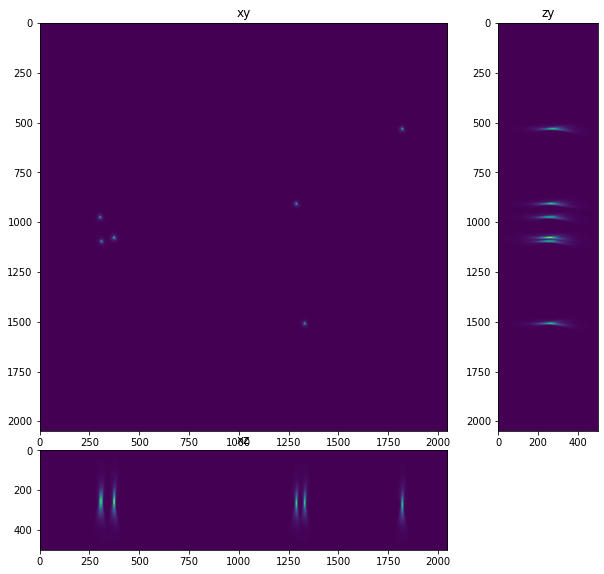

In [46]:
from skimage.filters import median
from skimage.morphology import cube
im = median(im, cube(3))
fig = show_xyz_max(im,1,10)

## Preprocessing

Preprocessing may need to be tweaked for bead images of different characteristics.  In this case we perform a crude background subtraction by subtracting ```1.25*mean``` from the image.

In [47]:
im=im.astype('float32')
print(im.mean())

im=im-1.25*im.mean()
im[im<=0]=.1
print(im.min(), im.max(), im.mean())

0.14610183
0.1 3881.8174 0.2457666


## Threshold the beads

In this case a simple global Otsu does an alright job at thresholding the beads.  This step may need to be tweaked for images with different characteristics.

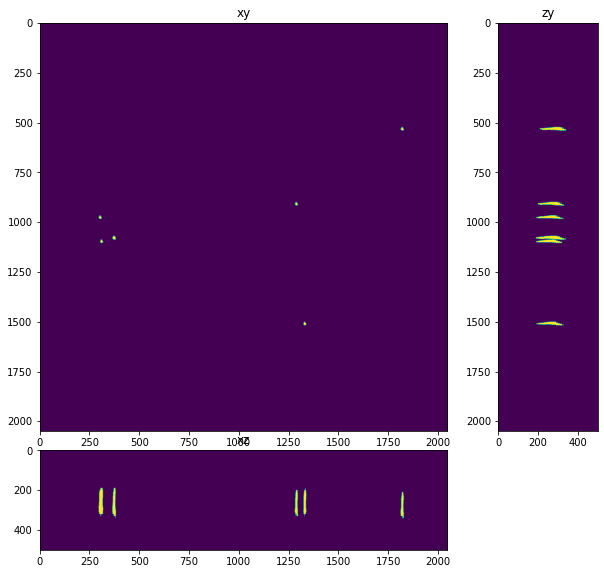

In [48]:
thresholded = im_median>threshold_otsu(im)
fig=show_xyz_max(thresholded,1,10)

## Find bead centroids

In this step we create a label image, create region properties for each label so we can get the centroid of each bead.  We create an empty image and draw a point at each centroid.  This aproximates the 'true object' of the field of sub-resolution beads

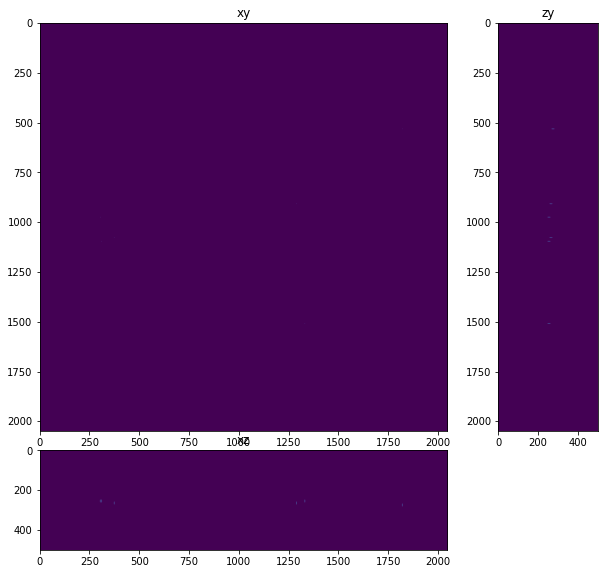

In [49]:
labels=label(thresholded)

from skimage.measure import regionprops
import numpy as np
centroids = np.zeros_like(labels)

objects = regionprops(labels)

for o in objects:
    centroids[int(o.centroid[0]),int(o.centroid[1]),int(o.centroid[2])]=1
fig=show_xyz_max(centroids,1,10)

# Note drawing centroids is wrapped in the below convenience method
# from tnia.segmentation.rendering import draw_centroids
# centroids = draw_centroids(thresholded)

## Aproximate PSF using 'reverse Deconvolution' a.k.a. PSF Distilling

In this step we perform a reverse deconvolution to solve for the PSF.  The acquired image is the convolution of a PSF and a 'true object'.  The 'true object' is the deconvolution of the image using the PSF.  However if we know the true object (in this case a field of sub-resolution beads) we can reverse the role of object and PSF, and solve for the PSF
```
Image=convolution(object,psf)

object=deconvolution(image,psf)

psf=deconvolution(image,object)
```

We use clij to perform the Richardson Lucy deconvolution however any implementation of Richardson Lucy deconvolution could be used at this step

get lib


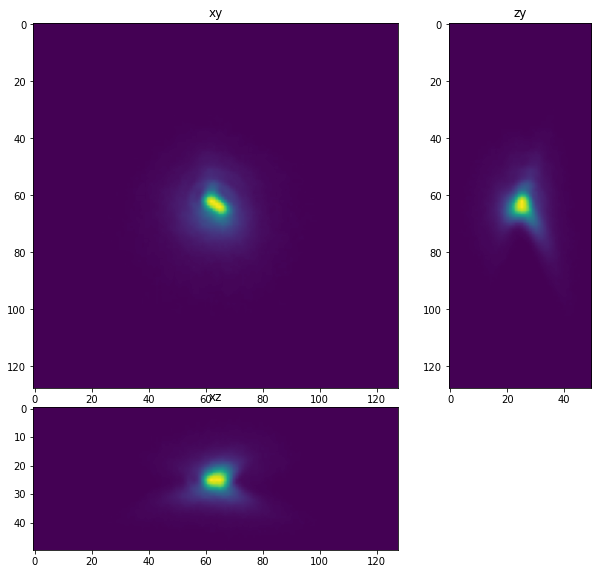

In [50]:
from clij2fft.richardson_lucy import richardson_lucy
im_32=im.astype('float32')
centroids_32=centroids.astype('float32')
first_guess=np.ones_like(im_32)
psf=richardson_lucy(im_32, centroids_32, 200)#, first_guess=first_guess)
psf_xy=64
psf_cropped=psf[:,1024-psf_xy:1024+psf_xy,1024-psf_xy:1024+psf_xy]
fig = show_xyz_max(psf_cropped)

## View in 3D

If we have napari installed we can view our PSF in 3D

In [51]:
# start napari
import napari
viewer = napari.Viewer()

# show images
viewer.add_image(psf, scale = [3,1,1])
#viewer.add_image(im, scale = [3,1,1])
#viewer.add_image(thresholded, scale = [3,1,1])

C:\Users\bnort\anaconda3\envs\tnia_deconware\lib\site-packages\napari\_qt\__init__.py:53: UserWarning: 

IMPORTANT:
You are using QT version 5.9.7, but version 5.15.4 was also found in your environment.
This usually happens when you 'conda install' something that also depends on PyQt
*after* you have pip installed napari (such as jupyter notebook).
You will likely run into problems and should create a fresh environment.
If you want to install conda packages into the same environment as napari,
please add conda-forge to your channels: https://conda-forge.org

  warn(message=warn_message)
C:\Users\bnort\anaconda3\envs\tnia_deconware\lib\site-packages\napari_tools_menu\__init__.py:165: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsM

<Image layer 'psf' at 0x1ce34799460>

Exception in callback BaseAsyncIOLoop._handle_events(6552, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(6552, 1)>
Traceback (most recent call last):
  File "C:\Users\bnort\anaconda3\envs\tnia_deconware\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\bnort\anaconda3\envs\tnia_deconware\lib\site-packages\tornado\platform\asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "C:\Users\bnort\anaconda3\envs\tnia_deconware\lib\site-packages\zmq\eventloop\zmqstream.py", line 448, in _handle_events
    self._handle_recv()
  File "C:\Users\bnort\anaconda3\envs\tnia_deconware\lib\site-packages\zmq\eventloop\zmqstream.py", line 477, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\bnort\anaconda3\envs\tnia_deconware\lib\site-packages\zmq\eventloop\zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\bnort\anaconda3\envs\tnia_deconware\lib\site-pac

call skimage rl
get lib


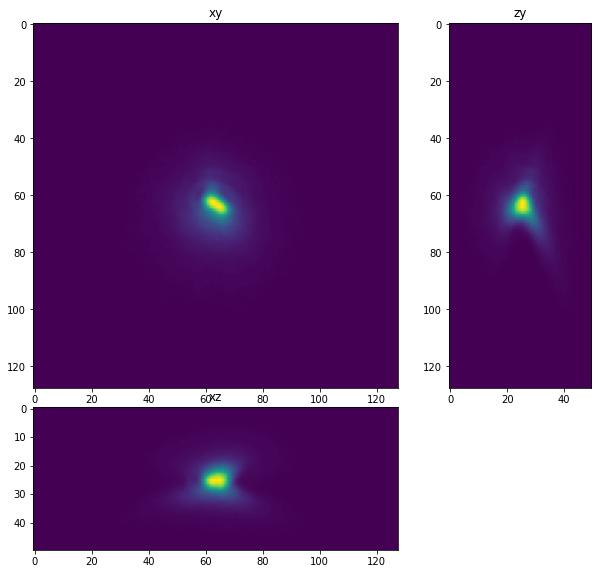

In [55]:
# note that the above steps can be accessed from a convenience function as follows
from tnia.deconvolution.psfs import psf_from_beads
psf,_,_ =psf_from_beads(im_orig, 1.25, True)
psf=psf[:,1024-psf_xy:1024+psf_xy,1024-psf_xy:1024+psf_xy]
fig = show_xyz_max(psf)